#  ✨ **Quora Question Pairs Prediction - NLP Final Project** ✨ 


---
**Digvijay Singh** - A2305320101

**Raj Hada** - A2305320059



---

# **Importing Required Libraries:**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from sklearn.metrics import accuracy_score,confusion_matrix,precision_score, recall_score,classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Bidirectional
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from bs4 import BeautifulSoup
import warnings
warnings.filterwarnings("ignore")

#  **Importing The Data:**

In [2]:
df = pd.read_csv('train.csv')

In [3]:
print(f'\033[1m_______________________________ Shape of the data: {df.shape} __________________________________\033[0m')
print("_____________________________________________data________________________________________________")
df.head()

_______________________________ Shape of the data: (404290, 6) __________________________________
_____________________________________________data________________________________________________


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# **Data Isights:**

In [4]:
new_df = df.sample(30000,random_state=2)
new_df['is_duplicate'].value_counts()

is_duplicate
0    19013
1    10987
Name: count, dtype: int64

In [5]:
new_df[['question1','question2','is_duplicate']].iloc[4]

question1                     Consequences of Bhopal gas tragedy?
question2       What was the reason behind the Bhopal gas trag...
is_duplicate                                                    0
Name: 151235, dtype: object

# **Preprocessing Step:**

**The preprocess(q) function performs several text preprocessing steps on the input text q. Let's go through each step:**
* Lowercasing and Stripping
* Special Character Replacement
* Removing '[math]' Pattern
* Number Representation
* Decontracting Words
* HTML Tag Removal
* Punctuation Removal

**Finally, the preprocessed text q is returned by the function.**

**Overall, the preprocess() function aims to clean and normalize the input text by removing special characters, standardizing numbers, expanding contractions, removing HTML tags, and eliminating punctuation. These preprocessing steps help in preparing the text data for further analysis or natural language processing tasks.**

In [6]:
def preprocess(q):
    
    q = str(q).lower().strip()
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    # https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
    # https://stackoverflow.com/a/19794953
    contractions = { 
    "ain't": "am not",
    "aren't": "are not",
    "can't": "can not",
    "can't've": "can not have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }

    q_decontracted = []

    for word in q.split():
        if word in contractions:
            word = contractions[word]

        q_decontracted.append(word)

    q = ' '.join(q_decontracted)
    q = q.replace("'ve", " have")
    q = q.replace("n't", " not")
    q = q.replace("'re", " are")
    q = q.replace("'ll", " will")
    
    # Removing HTML tags
    q = BeautifulSoup(q)
    q = q.get_text()
    
    # Remove punctuations
    pattern = re.compile('\W')
    q = re.sub(pattern, ' ', q).strip()

    
    return q
    

In [7]:
preprocess("I've already! wasn't <b>done</b>?")

'i have already  was not done'

In [8]:
new_df['question1'] = new_df['question1'].apply(preprocess)
new_df['question2'] = new_df['question2'].apply(preprocess)

In [9]:
new_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
398782,398782,496695,532029,what is the best marketing automation tool for...,what is the best marketing automation tool for...,1
115086,115086,187729,187730,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...,0
327711,327711,454161,454162,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...,0
367788,367788,498109,491396,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...,0
151235,151235,237843,50930,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy,0


# **Calculating Some Useful Features:**

Following lines of code add two new columns to the DataFrames new_df, respectively, containing the lengths of the values in the question1 and question2 columns.

In [10]:
new_df['q1_len'] = new_df['question1'].str.len() 
new_df['q2_len'] = new_df['question2'].str.len()

These lines of code add two new columns to the DataFrames new_df , respectively, containing the number of words in each sentence of the question1 and question2 columns. The number of words is calculated by splitting the sentences by spaces and counting the resulting words.

In [11]:
new_df['q1_num_words'] = new_df['question1'].apply(lambda row: len(row.split(" ")))
new_df['q2_num_words'] = new_df['question2'].apply(lambda row: len(row.split(" ")))


Defines a function called common_words that takes a row as input. Inside the function, it splits the sentences in the question1 and question2 columns of the row into words using the space character as a delimiter. It then converts the words to lowercase and removes any leading or trailing whitespace. Next, it creates sets w1 and w2 from these processed words. Finally, it returns the length of the intersection (&) of w1 and w2, representing the number of common words between the two sentences. This function can be used to calculate the number of common words for each row in a DataFrame.

In [12]:
def common_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return len(w1 & w2)

In [13]:
new_df['word_common'] = new_df.apply(common_words, axis=1)


Defines a function called total_words that takes a row as input. It splits the values in the 'question1' and 'question2' columns of the row into individual words and converts them to lowercase after removing leading and trailing spaces. It then creates sets of unique words for both 'question1' and 'question2'. Finally, it returns the total count of unique words in both questions combined by adding the lengths of the two sets.

In [14]:
def total_words(row):
    w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
    return (len(w1) + len(w2))

In [15]:
new_df['word_total'] = new_df.apply(total_words, axis=1)


In [16]:
new_df['word_share'] = round(new_df['word_common']/new_df['word_total'],2)


# **Preprocessings Function for removing stop words , replacing cotractions and tokenization:**

**Defines a function called fetch_token_features that takes a row as input. It performs several operations to extract token-based features from the 'question1' and 'question2' columns of the row. Here's a summary of what the code does:**

It imports the stopwords from the NLTK (Natural Language Toolkit) corpus for the English language.

It initializes a list token_features with eight elements, all initially set to 0.0.

The 'question1' and 'question2' values from the row are assigned to variables q1 and q2, respectively.

It splits q1 and q2 into individual tokens (words).

If either q1 or q2 has no tokens (empty), it returns the token_features list.

It filters out the stopwords from q1 and q2, creating sets of non-stopword words.

It also creates sets of stopwords from q1 and q2.

It calculates the count of common non-stopword words, common stopwords, and common tokens between q1 and q2.

The token-based features are computed and stored in the token_features list as follows:

**Index 0**: Ratio of common non-stopword words to the minimum length of q1_words and q2_words.

**Index 1**: Ratio of common non-stopword words to the maximum length of q1_words and q2_words.

**Index 2**: Ratio of common stopwords to the minimum length of q1_stops and q2_stops.

**Index 3**: Ratio of common stopwords to the maximum length of q1_stops and q2_stops.

**Index 4**: Ratio of common tokens to the minimum length of q1_tokens and q2_tokens.

**Index 5**: Ratio of common tokens to the maximum length of q1_tokens and q2_tokens.

**Index 6**: Indicator (1 or 0) whether the last word of q1 is the same as the last word of q2.

**Index 7**: Indicator (1 or 0) whether the first word of q1 is the same as the first word of q2.

Finally, the token_features list is returned as the output.

In [17]:
# Advanced Features
from nltk.corpus import stopwords

def fetch_token_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    SAFE_DIV = 0.0001 

    STOP_WORDS = stopwords.words("english")
    
    token_features = [0.0]*8
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features

    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    return token_features


In [18]:
token_features = new_df.apply(fetch_token_features, axis=1)

new_df["cwc_min"]       = list(map(lambda x: x[0], token_features))
new_df["cwc_max"]       = list(map(lambda x: x[1], token_features))
new_df["csc_min"]       = list(map(lambda x: x[2], token_features))
new_df["csc_max"]       = list(map(lambda x: x[3], token_features))
new_df["ctc_min"]       = list(map(lambda x: x[4], token_features))
new_df["ctc_max"]       = list(map(lambda x: x[5], token_features))
new_df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
new_df["first_word_eq"] = list(map(lambda x: x[7], token_features))

In [19]:
pip install distance

In [20]:
import distance

def fetch_length_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    length_features = [0.0]*3
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return length_features
    
    # Absolute length features
    length_features[0] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    length_features[1] = (len(q1_tokens) + len(q2_tokens))/2
    
    strs = list(distance.lcsubstrings(q1, q2))
    length_features[2] = len(strs[0]) / (min(len(q1), len(q2)) + 1)
    
    return length_features
    

In [21]:
length_features = new_df.apply(fetch_length_features, axis=1)

new_df['abs_len_diff'] = list(map(lambda x: x[0], length_features))
new_df['mean_len'] = list(map(lambda x: x[1], length_features))
new_df['longest_substr_ratio'] = list(map(lambda x: x[2], length_features))

In [22]:
pip install fuzzywuzzy

Note: you may need to restart the kernel to use updated packages.


In [23]:
# Fuzzy Features
from fuzzywuzzy import fuzz

def fetch_fuzzy_features(row):
    
    q1 = row['question1']
    q2 = row['question2']
    
    fuzzy_features = [0.0]*4
    
    # fuzz_ratio
    fuzzy_features[0] = fuzz.QRatio(q1, q2)

    # fuzz_partial_ratio
    fuzzy_features[1] = fuzz.partial_ratio(q1, q2)

    # token_sort_ratio
    fuzzy_features[2] = fuzz.token_sort_ratio(q1, q2)

    # token_set_ratio
    fuzzy_features[3] = fuzz.token_set_ratio(q1, q2)

    return fuzzy_features

In [24]:
fuzzy_features = new_df.apply(fetch_fuzzy_features, axis=1)

# Creating new feature columns for fuzzy features
new_df['fuzz_ratio'] = list(map(lambda x: x[0], fuzzy_features))
new_df['fuzz_partial_ratio'] = list(map(lambda x: x[1], fuzzy_features))
new_df['token_sort_ratio'] = list(map(lambda x: x[2], fuzzy_features))
new_df['token_set_ratio'] = list(map(lambda x: x[3], fuzzy_features))

In [25]:
print(new_df.shape)

(30000, 28)


# **Subsetting Required Data For Modeling:**

In [26]:
ques_df = new_df[['question1','question2']]
ques_df.head(4)

,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...


# **Preparing Data Countvectorizer To Get Bag of words:**

In [27]:
questions = list(ques_df['question1']) + list(ques_df['question2'])

In [28]:
questions[:10]

['what is the best marketing automation tool for small and mid size companies',
 'i am poor but i want to invest  what should i do',
 'i am from india and live abroad  i met a guy from france in a party i want to date him  how do i do that',
 'why do so many people in the u s  hate the southern states',
 'consequences of bhopal gas tragedy',
 'i killed a snake on a friday  there is a belief that when you kill a snake on a friday it will certainly take revenge  will i be killed',
 'is the royal family a net gain or a net loss to the british taxpayer',
 'if a huge asteroid was about to hit earth in x year  would we be able to find survival solutions in due time',
 'what would happen if a woman took viagra',
 'how could i improve my love to my girlfriend']

# **Bag of Words:**

CountVectorizer from the sklearn.feature_extraction.text module to convert a collection of text documents (questions) into a matrix representation of word occurrences.

Here's a summary of what the code does:

It imports the CountVectorizer class from the sklearn.feature_extraction.text module. It initializes an instance of CountVectorizer named vectorizer with the following parameters: max_features=1000: Limits the number of features (words) to the top 1000 most frequent words based on their occurrence in the training data. stop_words='english': Specifies that common English stopwords should be excluded from the vocabulary. It calls the fit_transform method of vectorizer on the questions data (presumably a list or array-like object containing the training questions) to learn the vocabulary and transform the questions into a matrix representation. fit_transform learns the vocabulary from the training data and returns a sparse matrix representation of the questions, where each row corresponds to a question, and each column represents a word in the vocabulary. The resulting matrix X_train is a sparse matrix with dimensions (number of questions, number of unique words in the vocabulary). It calls the transform method of vectorizer on the questions_t data (presumably a list or array-like object containing the test questions) to transform the test questions into the same matrix representation as the training data. transform applies the learned vocabulary from the training data to the test data and returns a sparse matrix representation. The resulting matrix X_test is a sparse matrix with the same dimensions as X_train. It calls the toarray method on X_train to convert the sparse matrix representation of the training data into a dense matrix. toarray converts the sparse matrix to a regular NumPy array. The resulting matrix bag_of_word is a dense matrix with dimensions (number of questions, number of unique words in the vocabulary), where each element represents the count of a word in a specific question.

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
# Initialize the CountVectorizer
vectorizer = CountVectorizer(max_features=1000,stop_words='english')

# Fit the vectorizer on the questions to learn the vocabulary
X_train = vectorizer.fit_transform(questions)

#X_test = vectorizer.transform(questions_t)

# Convert the bag-of-words representation to a dense matrix
bag_of_word = X_train.toarray()

In [30]:
X_train

<60000x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 174767 stored elements in Compressed Sparse Row format>

In [31]:
(X_train !=0).sum()

174767

In [32]:
print(f'What percentage of values are non zero : {(X_train !=0).sum()/np.prod(X_train.shape)}')

What percentage of values are non zero : 0.0029127833333333335


# **TFIDF Vectors:**

TfidfVectorizer to transform a collection of text questions into a matrix of TF-IDF values, and then converts the sparse matrix representation of the TF-IDF data into a dense matrix.

In [33]:
# Initialize the TfidfVectorizer and fit on the questions to learn the vocabulary
vectorizer = TfidfVectorizer(max_features=1000,stop_words='english')
tfidf = vectorizer.fit_transform(questions)
# Convert the TF-IDF representation to a dense matrix
tfidf = tfidf.toarray()

Here we retrieves the vocabulary learned by the TfidfVectorizer, prints a subset of the vocabulary, and prints a subset of the TF-IDF representation of the questions.

In [34]:
# Retrieve the vocabulary
vocabulary = vectorizer.get_feature_names_out()
# Print a subset of the vocabulary (optional)
# Print a subset of the vocabulary (optional)
max_vocabulary_display = 100
print("Vocabulary (subset):")
print(vocabulary[:max_vocabulary_display])

# Print a subset of the TF-IDF representation (optional)
max_tfidf_display = 100
print("TF-IDF representation (subset):")
print(tfidf[:max_tfidf_display])

Vocabulary (subset):
['10' '100' '11' '12' '12th' '13' '15' '16' '18' '1k' '20' '2014' '2015'
 '2016' '2017' '24' '2k' '30' '50' '500' 'able' 'abroad' 'access'
 'account' 'accounts' 'acne' 'act' 'actor' 'actually' 'add' 'address'
 'admission' 'advanced' 'advantages' 'advice' 'affect' 'age' 'ago' 'air'
 'alcohol' 'allowed' 'amazon' 'america' 'american' 'americans' 'ancient'
 'android' 'animals' 'answer' 'answers' 'anxiety' 'app' 'apple'
 'application' 'applications' 'apply' 'approach' 'apps' 'area' 'army'
 'art' 'ask' 'asked' 'attack' 'attractive' 'australia' 'available'
 'average' 'avoid' 'away' 'bad' 'balance' 'ban' 'bangalore' 'bank'
 'banning' 'based' 'basic' 'battle' 'beautiful' 'believe' 'belly'
 'benefits' 'best' 'better' 'big' 'biggest' 'birth' 'birthday' 'black'
 'block' 'blocked' 'blog' 'blood' 'blowing' 'blue' 'board' 'body'
 'bollywood' 'book']
TF-IDF representation (subset):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0.

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit the vectorizer on the questions to learn the vocabulary
bag_of_words = vectorizer.fit_transform(questions)

# Convert the bag-of-words representation to a dense matrix
bag_of_words = bag_of_words.toarray()

# Print the vocabulary (optional)
print("Vocabulary:")
print(vectorizer.get_feature_names_out())

# Print the bag-of-words representation (optional)
print("Bag-of-words representation:")
print(bag_of_words)

Vocabulary:
['00' '000' '000rs' ... '逆転の法則' '那年那兔那些事儿' '飛簷走壁']
Bag-of-words representation:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


# **Applying word2vec as well:**

In [36]:
import gensim

In [37]:
questions = list(ques_df['question1']) + list(ques_df['question2'])

The simple_preprocess function to preprocess each sentence in the questions list and stores the processed sentences in the ques_sent list.

In [38]:
ques_sent = []
for sentence in questions:
    ques_sent.append(gensim.utils.simple_preprocess(sentence))

In following lines of code we initializes a Word2Vec model object with specific parameters:

window=2 sets the maximum distance between the target word and its context words to 2. min_count=3 sets the minimum frequency count of words to 3. Words that occur less frequently than this will be ignored. sg=1 indicates the use of the Skip-gram algorithm. Alternative value of sg=0 would use the Continuous Bag of Words (CBOW) algorithm. vector_size=100 sets the dimensionality of the word vectors to 100. It builds the vocabulary of the Word2Vec model by calling the build_vocab method and passing the preprocessed sentences (ques_sent).

It trains the Word2Vec model by calling the train method and passing the preprocessed sentences (ques_sent) as the training corpus.

corpus_iterable specifies the input corpus as an iterable of sentences. total_examples specifies the total number of sentences in the corpus. epochs specifies the number of training epochs (passes over the corpus) to perform. After training, it retrieves the word vectors from the trained model and stores them in the w2v dictionary.

model.wv.index_to_key retrieves the vocabulary words as a list. model.wv.vectors.round(3) retrieves the corresponding word vectors, rounded to 3 decimal places. dict(zip(...)) creates a dictionary mapping each word to its vector.

In [39]:
model  = gensim.models.Word2Vec(window=2,min_count=3,sg=1,vector_size=100)

In [40]:
model.build_vocab(ques_sent)

In [41]:
model.train(corpus_iterable=ques_sent,total_examples= model.corpus_count, epochs=model.epochs)

(2174490, 3150050)

In [42]:
w2v = dict(zip(model.wv.index_to_key, (model.wv.vectors.round(3))))

In [43]:
w2v['what']

array([-0.466,  0.205,  0.248,  0.173,  0.091, -0.746,  0.238,  0.483,
       -0.536, -0.426, -0.012, -0.352, -0.054,  0.304,  0.235, -0.136,
        0.098, -0.223, -0.14 , -0.173,  0.505,  0.055,  1.087, -1.136,
        0.688,  0.04 ,  0.328,  0.4  , -0.571, -0.061,  0.929, -0.308,
        0.103, -0.291,  0.332,  0.162,  0.115,  0.333,  0.131,  0.489,
        0.136,  0.034, -0.685, -0.459,  0.373,  0.423,  0.296,  0.316,
        0.028,  0.055,  0.401, -0.794, -0.286, -0.107,  0.161,  0.261,
        0.098,  0.709, -0.184,  0.568, -0.201,  0.166,  0.327, -0.24 ,
       -0.355,  0.398,  0.733, -0.2  , -0.093,  0.887, -0.283,  0.197,
        0.483, -0.254,  0.812, -0.342, -0.133,  0.102,  0.015, -0.018,
       -0.848,  0.364, -0.137,  0.566, -0.188, -0.411, -0.067, -0.305,
        0.09 ,  0.165,  0.467, -0.132,  0.365, -0.565,  0.462,  0.015,
        0.506, -0.086,  0.062, -0.348], dtype=float32)

In [44]:
w2v['why']

array([-0.643,  1.095, -0.189, -0.094, -0.088, -0.67 , -0.123,  0.317,
       -0.333, -0.911, -0.072, -0.182,  0.069,  0.094,  0.562,  0.068,
        0.196, -0.341, -0.214, -0.531, -0.029,  0.033,  0.801, -0.272,
        0.133,  0.325, -0.422, -0.395, -0.086,  0.246,  0.908, -0.381,
        0.379, -0.022, -0.054,  0.296, -0.058,  0.272, -0.074, -0.318,
       -0.347,  0.05 ,  0.401,  0.036,  0.166, -0.396, -0.064, -0.002,
        0.048,  0.179,  0.423, -0.339,  0.032, -0.025,  0.032,  0.496,
        0.274,  0.412, -0.592,  0.216,  0.085,  0.527,  0.476,  0.349,
        0.225,  0.444, -0.202,  0.241, -0.151,  0.138,  0.339,  0.29 ,
        0.458,  0.358,  0.509,  0.38 ,  0.311,  0.362,  0.045,  0.004,
        0.101, -0.425, -0.227, -0.171,  0.499,  0.131,  0.481,  0.26 ,
       -0.369, -0.141,  0.634,  0.34 ,  0.118, -0.342,  0.451,  0.145,
        0.353, -0.028,  0.335, -0.353], dtype=float32)

# **TF-IDF Vector For word2vec:**

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [46]:
tfidf1 = TfidfVectorizer()

In [47]:
tfidf1.fit_transform(questions)

<60000x26200 sparse matrix of type '<class 'numpy.float64'>'
	with 606923 stored elements in Compressed Sparse Row format>

In [48]:
a = tfidf1.vocabulary_.items()

# **Creating a dictionary word2weight that maps each word in the vocabulary of a TF-IDF vectorizer (tfidf1) to its corresponding IDF (Inverse Document Frequency) weight:**

In [49]:
word2weight = [(w, round(tfidf1.idf_[i])) for w, i in tfidf1.vocabulary_.items()]

In [50]:
word2weight = dict(word2weight)

In [51]:
model.wv.similar_by_word('pakistan',topn=15)

[('russia', 0.9282010197639465),
 ('china', 0.8869412541389465),
 ('strike', 0.8590531945228577),
 ('declare', 0.8475733995437622),
 ('surgical', 0.844558835029602),
 ('kashmir', 0.8319688439369202),
 ('terrorists', 0.8313188552856445),
 ('defeat', 0.8273079991340637),
 ('israel', 0.8259707689285278),
 ('attack', 0.8259010314941406),
 ('declared', 0.8247849941253662),
 ('vietnam', 0.8246451616287231),
 ('communist', 0.820993185043335),
 ('elections', 0.8180903196334839),
 ('north', 0.8146007657051086)]

# **Data splitting in train test and val sets also prepration for modeling:**

Defines a function document_vector that calculates a document vector based on a given document.

Here's a summary of what the code does:

It checks the length of the input document:

If the document has no words (len(doc.split()) == 0) or has only one word (len(doc.split()) == 1), it returns a zero vector of shape (100). If the document has more than one word:

It initializes an empty list doc_vec to store the word vectors multiplied by their corresponding TF-IDF weights. It initializes a variable tfidf_weight_sum to store the sum of TF-IDF weights. It iterates over each word in the document. For each word that exists in both the word2vec model (w2v) and the TF-IDF weights (word2weight), it calculates the TF-IDF weight for the word based on its frequency in the document. It multiplies the word vector (w2v[word]) by the TF-IDF weight and appends the result to the doc_vec list. It accumulates the TF-IDF weight in the tfidf_weight_sum variable. After processing all the words in the document:

If no valid word vectors were found (len(doc_vec) == 0), it returns a zero vector of shape (100). Otherwise, it calculates the weighted average of the word vectors by summing them (np.sum(doc_vec, axis=0)) and dividing by the total TF-IDF weight (tfidf_weight_sum). The resulting document vector is rounded to 3 decimal places using np.round().

In [52]:
def document_vector(doc):
    if len(doc.split()) == 0:
        return np.zeros(shape=(100))
    elif len(doc.split()) == 1:
        return np.zeros(shape=(100))
    else:
#         doc = [word for word in doc.split() if word in model.wv.index_to_key]
#         return np.mean(model.wv[doc],axis=0).round(2)
        doc_vec = []
        tfidf_weight_sum = 0
        for word in doc.split():
            if word in w2v.keys() and word in word2weight.keys():
                tfidf_weight = word2weight[word]*doc.split().count(word)/len(doc.split())
                product = (w2v[word]*tfidf_weight)
                doc_vec.append(product)
                tfidf_weight_sum = tfidf_weight_sum + tfidf_weight
                #print(f"weight of {word} : {word2weight[word]}")
                #print(f"word vector of {word} : {w2v[word]}")
                #print(product)\n",
        #print(doc_vec)
        if len(doc_vec) == 0:
            return np.round(np.sum(doc_vec,axis=0)/1,3)
        else:
            return np.round(np.sum(doc_vec,axis=0)/tfidf_weight_sum,3)

In [53]:
from tqdm import tqdm

The question data by applying the document_vector function to each question in the dataset. It creates two separate lists (X and X2) to store the document vectors for the questions in 'question1' and 'question2' columns, respectively.

It iterates over each question in the 'question1' column of the dataset. For each question, it calls the document_vector function to calculate the document vector and appends it to the X list. It performs a similar process for the 'question2' column and appends the document vectors to the X2 list. The X and X2 lists are converted into numpy arrays (X = np.array(X) and X2 = np.array(X2)). Two temporary data frames (temp_df1 and temp_df2) are created using the document vectors as the data and the original data frame index as the index. The temporary data frames are concatenated along the column axis to create a new data frame (temp_df). The 'id', 'qid1', 'qid2', 'question1', and 'question2' columns are dropped from the new_df data frame, and the result is stored in final_df. The shape of final_df is printed. The final_df and temp_df data frames are concatenated along the column axis to create the complete_df. The shape of complete_df is printed. The head() method is called on complete_df to display the first few rows.

In [54]:
X = []
for doc in tqdm(ques_df['question1']):
    X.append(document_vector(doc))

100%|██████████| 30000/30000 [00:02<00:00, 10617.11it/s]


In [55]:
X2 = []
for doc in tqdm(ques_df['question2']):
    X2.append(document_vector(doc))

100%|██████████| 30000/30000 [00:02<00:00, 10981.25it/s]


In [56]:
X = np.array(X)

In [57]:
X2 = np.array(X2)

In [58]:
temp_df1 = pd.DataFrame(X, index= new_df.index)
temp_df2 = pd.DataFrame(X2, index= new_df.index)
temp_df = pd.concat([temp_df1, temp_df2], axis=1)

In [59]:
temp_df.shape

(30000, 200)

In [60]:
final_df = new_df.drop(columns=['id','qid1','qid2','question1','question2'])
print(final_df.shape)

(30000, 23)


In [61]:
complete_df = pd.concat([final_df, temp_df], axis=1)
print(complete_df.shape)
complete_df.head()

(30000, 223)


,is_duplicate,q1_len,q2_len,q1_num_words,q2_num_words,word_common,word_total,word_share,cwc_min,cwc_max,...,90,91,92,93,94,95,96,97,98,99
398782,1,75,76,13,13,12,26,0.46,0.874989,0.874989,...,0.303,0.120,-0.045,-0.109,0.332,0.191,-0.070,-0.121,0.078,-0.106
115086,0,48,56,13,16,8,24,0.33,0.666644,0.499988,...,0.204,0.173,0.087,0.037,0.606,0.024,0.204,-0.152,0.060,-0.249
327711,0,104,119,28,21,4,38,0.11,0.000000,0.000000,...,0.239,0.144,-0.000,-0.010,0.474,0.012,-0.207,-0.102,0.082,-0.159
367788,0,58,145,14,32,1,34,0.03,0.000000,0.000000,...,0.381,0.112,0.386,0.138,0.671,-0.145,0.128,0.155,0.071,0.188
151235,0,34,49,5,9,3,13,0.23,0.749981,0.599988,...,0.208,0.112,0.124,-0.142,0.500,0.064,-0.196,0.052,0.010,-0.090


In [62]:
complete_df.columns[0:24]

Index([        'is_duplicate',               'q1_len',               'q2_len',
               'q1_num_words',         'q2_num_words',          'word_common',
                 'word_total',           'word_share',              'cwc_min',
                    'cwc_max',              'csc_min',              'csc_max',
                    'ctc_min',              'ctc_max',         'last_word_eq',
              'first_word_eq',         'abs_len_diff',             'mean_len',
       'longest_substr_ratio',           'fuzz_ratio',   'fuzz_partial_ratio',
           'token_sort_ratio',      'token_set_ratio',                      0],
      dtype='object')

In [63]:
complete_df.isnull().sum()

is_duplicate    0
q1_len          0
q2_len          0
q1_num_words    0
q2_num_words    0
               ..
95              0
96              0
97              0
98              0
99              0
Length: 223, dtype: int64

In [64]:
from sklearn.model_selection import train_test_split
X_tr,X_te,y_tr,y_te = train_test_split(complete_df.iloc[:,1:],complete_df.iloc[:,0],test_size=0.2,random_state=1)

**To train an LSTM model for binary classification:**

It splits the data into training and test sets using train_test_split, where complete_df.iloc[:,1:].values represents the input features (X) and complete_df.iloc[:,0].values represents the target variable (y). It applies feature scaling using StandardScaler to standardize the input features. The scaler is fit on the training data and then applied to transform both the training and test data. The input data for the LSTM model is reshaped to have the shape (number of samples, number of time steps, number of features) using np.reshape. In this case, the number of features is set toThe LSTM model is defined using Sequential from Keras and consists of an LSTM layer with 128 units and a dense output layer with sigmoid activation. The model is compiled with the binary cross-entropy loss function, the Adam optimizer, and accuracy as the evaluation metric. The model is trained using the fit function, where X_train_lstm and y_train are the training data, epochs=10 specifies the number of training epochs, batch_size=64 determines the batch size, and validation_data is provided as (X_test_lstm, y_test) for validation during training. The training progress and performance metrics are stored in the lstm_hist variable.

In [65]:
X_train,X_test,y_train,y_test = train_test_split(complete_df.iloc[:,1:].values,complete_df.iloc[:,0].values,test_size=0.2,random_state=1)

In [66]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_stdscaled = scaler.transform(X_train)
X_test_stdscaled = scaler.transform(X_test)

In [67]:
# Reshape the input data for LSTM
X_train_lstm = np.reshape(X_train_stdscaled, (X_train_stdscaled.shape[0], X_train_stdscaled.shape[1], 1))
X_test_lstm = np.reshape(X_test_stdscaled, (X_test_stdscaled.shape[0], X_test_stdscaled.shape[1], 1))

In [68]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [69]:
# Train the BiLSTM model with validation data
lstm_hist = lstm_model.fit(X_train_lstm, y_train, epochs=26, batch_size=64, validation_data=(X_test_lstm, y_test))

Epoch 1/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 855s 2s/step - accuracy: 0.6471 - loss: 0.6455 - val_accuracy: 0.6595 - val_loss: 0.6387
Epoch 2/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 243ms/step - accuracy: 0.6587 - loss: 0.6280 - val_accuracy: 0.6610 - val_loss: 0.6261
Epoch 3/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 59s 156ms/step - accuracy: 0.6620 - loss: 0.6241 - val_accuracy: 0.6642 - val_loss: 0.6190
Epoch 4/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 56s 149ms/step - accuracy: 0.6651 - loss: 0.6194 - val_accuracy: 0.6708 - val_loss: 0.6173
Epoch 5/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 64s 172ms/step - accuracy: 0.6666 - loss: 0.6187 - val_accuracy: 0.6722 - val_loss: 0.6151
Epoch 6/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 96s 209ms/step - accuracy: 0.6718 - loss: 0.6142 - val_accuracy: 0.6758 - val_loss: 0.6152
Epoch 7/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 55s 145ms/step - accuracy: 0.6764 - loss: 0.6113 - val_accuracy: 0.6723 - val_loss: 0.6145
Epoch 8/26
375/375 ━━━━━━━━━━━━━━━━━━━━ 58s 155ms/step - accuracy: 0.6743 - loss: 0.6

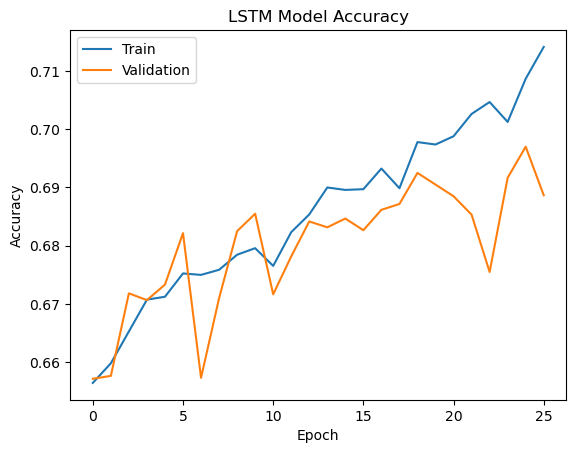

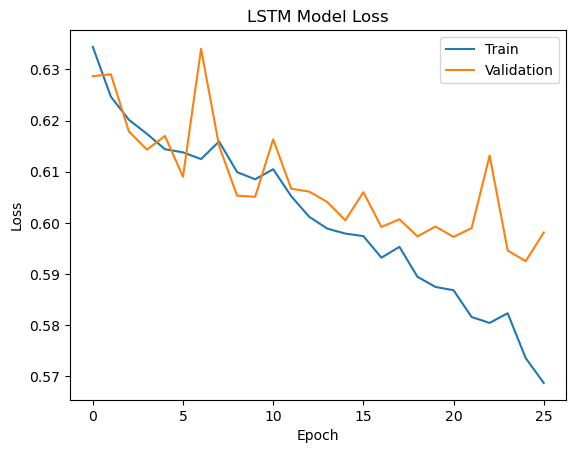

In [ ]:
#Plot the training history
plt.plot(lstm_hist.history['accuracy'])
plt.plot(lstm_hist.history['val_accuracy'])
plt.title('LSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(lstm_hist.history['loss'])
plt.plot(lstm_hist.history['val_loss'])
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

The results suggest that the LSTM model achieved moderate performance in terms of accuracy on both the training and validation sets. The model's performance on the validation set is slightly lower than its performance on the training set, indicating some degree of overfitting or a discrepancy between the training and validation data. Further analysis and adjustments may be necessary to improve the model's performance.

In [ ]:
# Predict on the test data
y_pred_prob = lstm_model.predict(X_test_lstm)
y_pred_lstm = (y_pred_prob > 0.5).astype(int)

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step


In [ ]:
# Convert the predicted values to 1D array
y_pred_lstm = np.squeeze(y_pred_lstm)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lstm)
print("Accuracy:", accuracy)

Accuracy: 0.6886666666666666


In [ ]:
# Get the indices of misclassified and correctly classified examples
lstm_misclassified_indices = np.where(y_pred_lstm != y_test)[0]
lstm_correct_indices = np.where(y_pred_lstm == y_test)[0]

# Get the corresponding sentences for misclassified examples
lstm_misclassified_sentences = new_df.iloc[lstm_misclassified_indices][['question1', 'question2']]

# Get the corresponding sentences for correctly classified examples
lstm_correct_sentences = new_df.iloc[lstm_correct_indices][['question1', 'question2']]

lstm_misclassified_sentences = pd.DataFrame(lstm_misclassified_sentences)
lstm_correct_classified_sentences = pd.DataFrame(lstm_correct_sentences)
print(f'Misclassified Sentences :\n ')
lstm_misclassified_sentences

Misclassified Sentences :
 


,question1,question2
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
16633,is the royal family a net gain or a net loss t...,why does the british royal family think it is ...
15268,how could i improve my love to my girlfriend,how do i improve my relationship with my girlf...
370895,i would like to start watching doctor who whe...,as a new viewer from which season should i st...
...,...,...
327775,how can we download torrents now after the ban...,can i download movies through yts in india
14674,how can i pass a drug test for meth in two days,how do i get meth out of my system in 3 days
36219,what hotel in kalpetta hill station would be s...,what hotel in jammu hill station would be safe...
78064,how do i prepare for a phone interview with go...,how should i prepare for a technical program m...


In [ ]:
print(f'correct classified Sentences :\n ')
lstm_correct_classified_sentences

correct classified Sentences :
 


,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy
244531,i killed a snake on a friday there is a belie...,do snakes really take revenge
396316,if a huge asteroid was about to hit earth in x...,a 100 mile wide asteroid is projected to hit e...
...,...,...
387284,how hard is it for a native english speaker to...,how hard is the russian language to learn for ...
161269,how do a junior high school students make mone...,how can a high school student make money
186264,how is the market for coredova which is bette...,i am a fresher currently i got a job in c ne...
380705,how do i find a perfect male hairstyle for me,how can i find the right hairstyle for me


In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred_lstm)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[3182  630]
 [1238  950]]


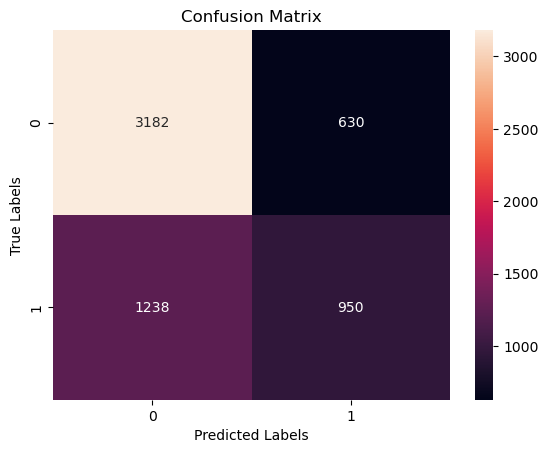

In [ ]:
# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred_lstm)
recall = recall_score(y_test, y_pred_lstm)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.6012658227848101
Recall: 0.43418647166361973


In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_lstm)
print(report)

              precision    recall  f1-score   support

           0       0.72      0.83      0.77      3812
           1       0.60      0.43      0.50      2188

    accuracy                           0.69      6000
   macro avg       0.66      0.63      0.64      6000
weighted avg       0.68      0.69      0.68      6000



# **BiLSTM Model:**

In [ ]:
# Define the BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(128), input_shape=(X_train_lstm.shape[1], 1)))
bilstm_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the BiLSTM model
hist = bilstm_model.fit(X_train_lstm, y_train, epochs=1, batch_size=64,validation_data=(X_test_lstm, y_test))

375/375 ━━━━━━━━━━━━━━━━━━━━ 163s 420ms/step - accuracy: 0.7266 - loss: 0.4864 - val_accuracy: 0.7335 - val_loss: 0.4795


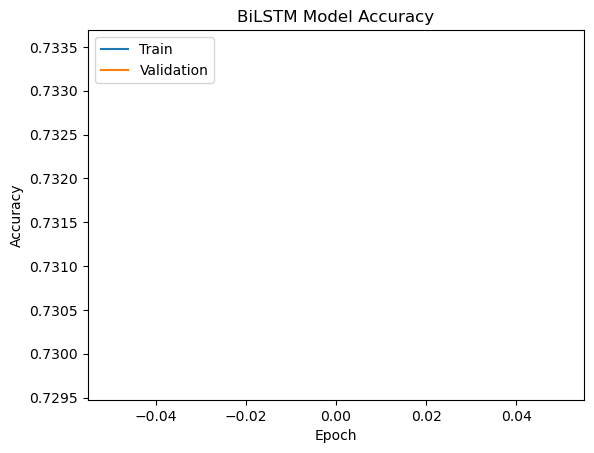

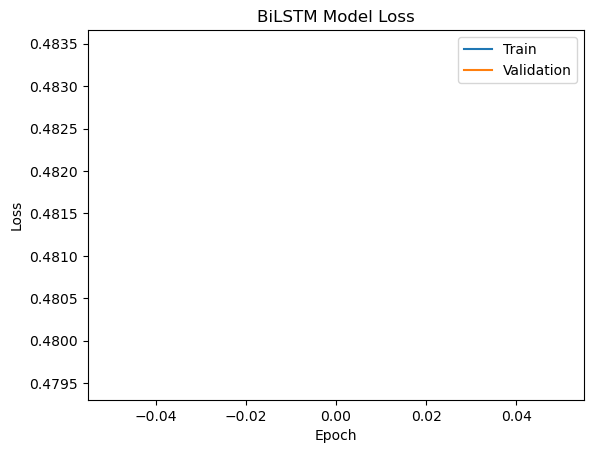

In [ ]:
# Plot the training history
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# Predict on the test data
y_pred_bilstm = bilstm_model.predict(X_test_lstm)

# Convert the predicted values to 1D array
y_pred_bilstm = np.squeeze(y_pred_bilstm)

188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step


In [ ]:
# Convert y_test to binary format
threshold = 0.5
y_test_binary = np.array(y_test > threshold, dtype=int)
y_pred_bilstm = np.array(y_pred_bilstm > threshold, dtype=int)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test_binary, y_pred_bilstm)
print("Accuracy:", accuracy)

Accuracy: 0.7335


In [ ]:
# Get the indices of misclassified and correctly classified examples
bilstm_misclassified_indices = np.where(y_pred_bilstm != y_test)[0]
bilstm_correct_indices = np.where(y_pred_bilstm == y_test)[0]

# Get the corresponding sentences for misclassified examples
bilstm_misclassified_sentences = new_df.iloc[bilstm_misclassified_indices][['question1', 'question2']]

# Get the corresponding sentences for correctly classified examples
bilstm_correct_sentences = new_df.iloc[bilstm_correct_indices][['question1', 'question2']]

bilstm_misclassified_sentences = pd.DataFrame(bilstm_misclassified_sentences)
bilstm_correct_classified_sentences = pd.DataFrame(bilstm_correct_sentences)
print(f'Misclassified Sentences :\n ')
bilstm_misclassified_sentences

Misclassified Sentences :
 


,question1,question2
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy
35957,how heaven is described in the bible,how is heaven described according the bible
...,...,...
14674,how can i pass a drug test for meth in two days,how do i get meth out of my system in 3 days
36219,what hotel in kalpetta hill station would be s...,what hotel in jammu hill station would be safe...
78064,how do i prepare for a phone interview with go...,how should i prepare for a technical program m...
387284,how hard is it for a native english speaker to...,how hard is the russian language to learn for ...


In [ ]:
print(f'Correct classified Sentences :\n ')
bilstm_correct_classified_sentences

Correct classified Sentences :
 


,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
244531,i killed a snake on a friday there is a belie...,do snakes really take revenge
16633,is the royal family a net gain or a net loss t...,why does the british royal family think it is ...
396316,if a huge asteroid was about to hit earth in x...,a 100 mile wide asteroid is projected to hit e...
399493,what would happen if a woman took viagra,does viagra really work
...,...,...
334531,what is the basic difference between 2g 2 5g 2...,what is the difference between 2g and 3g mobil...
161269,how do a junior high school students make mone...,how can a high school student make money
186264,how is the market for coredova which is bette...,i am a fresher currently i got a job in c ne...
380705,how do i find a perfect male hairstyle for me,how can i find the right hairstyle for me


Confusion Matrix:
[[2856  956]
 [ 643 1545]]


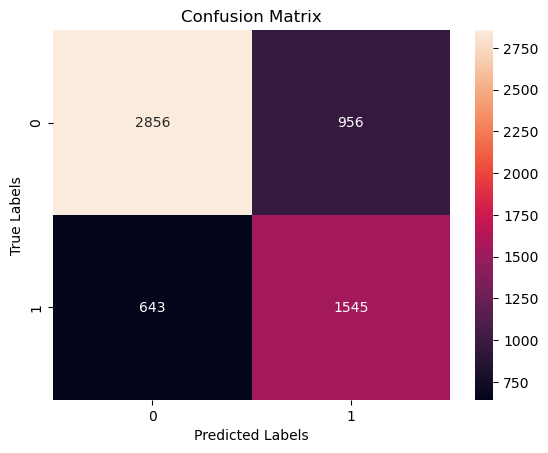

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_binary, y_pred_bilstm)
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate precision and recall
precision = precision_score(y_test, y_pred_bilstm)
recall = recall_score(y_test, y_pred_bilstm)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.6177528988404638
Recall: 0.7061243144424132


In [ ]:
# Generate classification report
report = classification_report(y_test, y_pred_bilstm)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.75      0.78      3812
           1       0.62      0.71      0.66      2188

    accuracy                           0.73      6000
   macro avg       0.72      0.73      0.72      6000
weighted avg       0.74      0.73      0.74      6000



The improved results of the BiLSTM classifier can be attributed to the use of bidirectional LSTM, which allows the model to capture information from both past and future contexts. The bidirectional nature helps the model understand the sequential dependencies in the input data more effectively, leading to enhanced performance in the classification task.

# **Machine Learning Models: RandomForestClassifiers and XGBclassifier:**

# 1. Random forest Classifier:

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier(n_estimators=250,criterion='gini',n_jobs=4)
rf.fit(X_train_stdscaled,y_train)

# Calculate train accuracy
y_train_pred = rf.predict(X_train_stdscaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Calculate test accuracy
y_test_pred = rf.predict(X_test_stdscaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.9999583333333333
Test Accuracy: 0.791


In [ ]:
# Get the indices of misclassified and correctly classified examples
rf_misclassified_indices = np.where(y_test_pred != y_test)[0]
rf_correct_indices = np.where(y_test_pred == y_test)[0]

# Get the corresponding sentences for misclassified examples
rf_misclassified_sentences = new_df.iloc[rf_misclassified_indices][['question1', 'question2']]

# Get the corresponding sentences for correctly classified examples
rf_correct_sentences = new_df.iloc[rf_correct_indices][['question1', 'question2']]

rf_misclassified_sentences = pd.DataFrame(rf_misclassified_sentences)
rf_correct_classified_sentences = pd.DataFrame(rf_correct_sentences)
print(f'Misclassified Sentences :\n ')
rf_misclassified_sentences

Misclassified Sentences :
 


,question1,question2
399493,what would happen if a woman took viagra,does viagra really work
35957,how heaven is described in the bible,how is heaven described according the bible
224223,what is it really like to be shot,what does it feel like to be shot
329152,how can i get my android phone s cracked scree...,i dropped a tv and it broke cracking the plas...
122112,how does the happn app know where my location ...,how does the happn app deal with stalking
...,...,...
14674,how can i pass a drug test for meth in two days,how do i get meth out of my system in 3 days
352576,does trump treat his employees kindly,does donald trump treat his employees well
36219,what hotel in kalpetta hill station would be s...,what hotel in jammu hill station would be safe...
78064,how do i prepare for a phone interview with go...,how should i prepare for a technical program m...


In [ ]:
print(f'Correct classified Sentences :\n ')
rf_correct_classified_sentences

Correct classified Sentences :
 


,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy
...,...,...
387284,how hard is it for a native english speaker to...,how hard is the russian language to learn for ...
161269,how do a junior high school students make mone...,how can a high school student make money
186264,how is the market for coredova which is bette...,i am a fresher currently i got a job in c ne...
380705,how do i find a perfect male hairstyle for me,how can i find the right hairstyle for me


Confusion Matrix:
[[3196  616]
 [ 638 1550]]


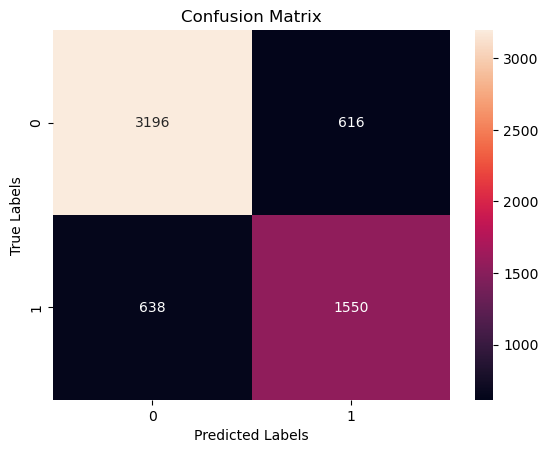

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate precision and recall
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7156048014773777
Recall: 0.7084095063985375


In [ ]:
# Generate classification report
report = classification_report(y_test, y_test_pred)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      3812
           1       0.72      0.71      0.71      2188

    accuracy                           0.79      6000
   macro avg       0.77      0.77      0.77      6000
weighted avg       0.79      0.79      0.79      6000



Overall, the Random Forest classifier achieves a relatively high test accuracy and captures a good number of true positives and true negatives. However, the possibility of overfitting should be considered due to the significantly higher training accuracy. Fine-tuning the model or exploring other algorithms might be necessary to further improve the performance and address any overfitting issues.

# 2. XGBoost Classifier:

In [ ]:
pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 262.6 kB/s eta 0:06:20
   ---------------------------------------- 0.0/99.8 MB 281.8 kB/s eta 0:05:54
   ---------------------------------------- 0.1/99.8 MB 595.3 kB/s eta 0:02:48
   ---------------------------------------- 0.2/99.8 MB 981.9 kB/s eta 0:01:42
   ---------------------------------------- 0.3/99.8 MB 1.2 MB/s eta 0:01:21
   ---------------------------------------- 0.4/99.8 MB 1.3 MB/s eta 0:01:16
   ---------------------------------------- 0

In [ ]:
from xgboost import XGBClassifier
xgb = XGBClassifier(eta=0.1,n_estimators=200,n_jobs=4, learning_rate=0.1)
xgb.fit(X_train_stdscaled,y_train)

# Calculate train accuracy
y_train_pred = xgb.predict(X_train_stdscaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)


# Calculate test accuracy
y_test_pred1 = xgb.predict(X_test_stdscaled)
test_accuracy = accuracy_score(y_test, y_test_pred1)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.957875
Test Accuracy: 0.796


In [ ]:
# Get the indices of misclassified and correctly classified examples
xgb_misclassified_indices = np.where(y_test_pred1 != y_test)[0]
xgb_correct_indices = np.where(y_test_pred1 == y_test)[0]

# Get the corresponding sentences for misclassified examples
xgb_misclassified_sentences = new_df.iloc[xgb_misclassified_indices][['question1', 'question2']]

# Get the corresponding sentences for correctly classified examples
xgb_correct_sentences = new_df.iloc[xgb_correct_indices][['question1', 'question2']]

xgb_misclassified_sentences = pd.DataFrame(xgb_misclassified_sentences)
xgb_correct_classified_sentences = pd.DataFrame(xgb_correct_sentences)
print(f'Misclassified Sentences :\n ')
xgb_misclassified_sentences

Misclassified Sentences :
 


,question1,question2
399493,what would happen if a woman took viagra,does viagra really work
370895,i would like to start watching doctor who whe...,as a new viewer from which season should i st...
224223,what is it really like to be shot,what does it feel like to be shot
329152,how can i get my android phone s cracked scree...,i dropped a tv and it broke cracking the plas...
122112,how does the happn app know where my location ...,how does the happn app deal with stalking
...,...,...
327775,how can we download torrents now after the ban...,can i download movies through yts in india
14674,how can i pass a drug test for meth in two days,how do i get meth out of my system in 3 days
36219,what hotel in kalpetta hill station would be s...,what hotel in jammu hill station would be safe...
78064,how do i prepare for a phone interview with go...,how should i prepare for a technical program m...


In [ ]:
print(f'Correct classified Sentences :\n ')
xgb_correct_classified_sentences

Correct classified Sentences :
 


,question1,question2
398782,what is the best marketing automation tool for...,what is the best marketing automation tool for...
115086,i am poor but i want to invest what should i do,i am quite poor and i want to be very rich wh...
327711,i am from india and live abroad i met a guy f...,t i e t to thapar university to thapar univers...
367788,why do so many people in the u s hate the sou...,my boyfriend doesnt feel guilty when he hurts ...
151235,consequences of bhopal gas tragedy,what was the reason behind the bhopal gas tragedy
...,...,...
387284,how hard is it for a native english speaker to...,how hard is the russian language to learn for ...
161269,how do a junior high school students make mone...,how can a high school student make money
186264,how is the market for coredova which is bette...,i am a fresher currently i got a job in c ne...
380705,how do i find a perfect male hairstyle for me,how can i find the right hairstyle for me


Confusion Matrix:
[[3216  596]
 [ 628 1560]]


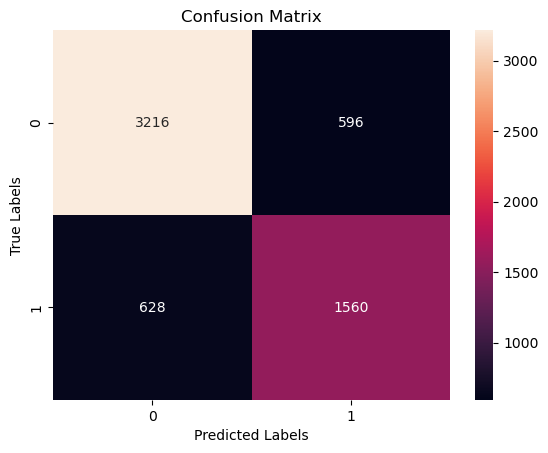

In [ ]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred1)
print("Confusion Matrix:")
print(cm)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate precision and recall
precision = precision_score(y_test, y_test_pred1)
recall = recall_score(y_test, y_test_pred1)

print("Precision:", precision)
print("Recall:", recall)

Precision: 0.7235621521335807
Recall: 0.7129798903107861


In [ ]:
# Generate classification report
report = classification_report(y_test, y_test_pred1)
print(report)

              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3812
           1       0.72      0.71      0.72      2188

    accuracy                           0.80      6000
   macro avg       0.78      0.78      0.78      6000
weighted avg       0.80      0.80      0.80      6000



Overall, the XGBoost classifier achieves a relatively high test accuracy and captures a good number of true positives and true negatives. It performs slightly better than the Random Forest classifier in terms of accuracy. However, similar to the Random Forest classifier, fine-tuning the model or exploring other algorithms might be necessary to further improve the performance and address any potential limitations.